In [2]:
using Flux
using Statistics
using Plots
using DifferentialEquations

In [2]:
# Approximating the function f(x) = 1 by training a neural network:

NN = Chain(Dense(10,32,tanh),
           Dense(32,32,tanh),
           Dense(32,5))

Chain(
  Dense(10 => 32, tanh),                # 352 parameters
  Dense(32 => 32, tanh),                # 1_056 parameters
  Dense(32 => 5),                       # 165 parameters
)                   # Total: 6 arrays, 1_573 parameters, 6.520 KiB.

In [4]:
# Our initial loss is quite bad

loss() = sum(abs2, sum(abs2, NN(rand(10)) .- 1) for i in 1:100)
loss()

2940.8113f0

In [5]:
# We now train our NN with 10000 random data sets

p = Flux.params(NN)

Flux.train!(loss, p, Iterators.repeated((), 10000), ADAM(0.1))

In [7]:
# We now have something that very closely approximates our desired function!

NN(rand(10))

5-element Vector{Float32}:
 0.99650156
 1.0049243
 1.001725
 0.99449396
 1.0087968

In [8]:
# Now let's try to create a neural network that's able to learn the solution to an
# ordinary differential equation: u' = cos 2πt

NNODE = Chain(x -> [x],
              Dense(1, 32, tanh),
              Dense(32, 1),
              first)


Chain(
  var"#7#8"(),
  Dense(1 => 32, tanh),                 # 64 parameters
  Dense(32 => 1),                       # 33 parameters
  first,
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

In [9]:
# To encode our initial condition of 1, we define a new function g dependent on NNODE
# that will automatically satisfy this condition
g(t) = t*NNODE(t) + 1f0 # This is our universal approximator

ϵ = sqrt(eps(Float32))
loss() = mean(abs2(((g(t + ϵ) - g(t)) / ϵ) - cos(2π*t)) for t in 0:1f-2:1f0)

loss (generic function with 1 method)

In [10]:
# We'll now train our neural network

opt = Flux.Descent(0.01)

data = Iterators.repeated((), 5000)
iter = 0

#Callback function to observe training
cb = function ()
    global iter += 1
    if iter % 500 == 0
        display(loss())
    end
end

display(loss())
Flux.train!(loss, Flux.params(NNODE), data, opt; cb=cb)


0.5241107010470423

0.49614086027513177

0.4746001083054023

0.40125189218826685

0.1978927344418572

0.03194643900565815

0.009059223961028904

0.006447457858315374

0.005878826192410942

0.005597737273200664

0.005337357317209639

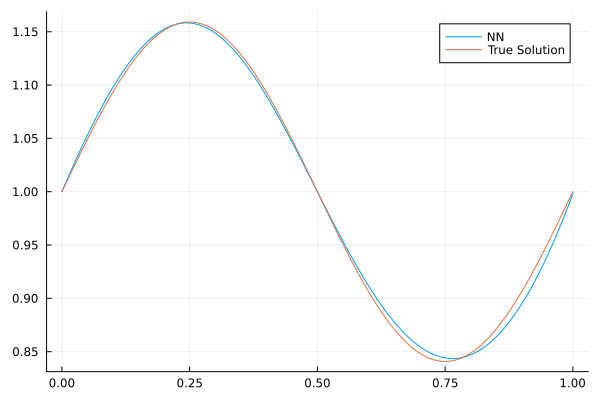

In [11]:
# We can see that our trained NN gives us something incredibly close to the true ODE solution

t = 0:0.001:1.0
plot(t, g.(t), label="NN")
plot!(t, 1.0 .+ sin.(2π.*t)/2π, label="True Solution")

# PINN Introduction witha Harmonic Oscillator

Let's suppose we're trying to model the force on a nonideal spring with the following behavior:
$$ x'' = -kx + 0.1\sin(x) $$

Let's see the true solution to this differential equation:

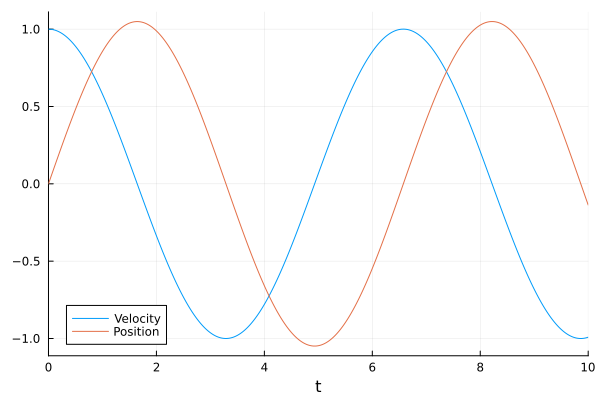

In [14]:
k = 1.0
force(dx, x, k, t) = -k*x + 0.1sin(x)
prob = SecondOrderODEProblem(force, 1.0, 0.0, (0.0, 10.0), k)
sol = solve(prob)
plot(sol, label=["Velocity" "Position"])

What if we only had a limited data set, that alone would leave us pretty much in the dark with regards to the oscillatory behavior of our spring?

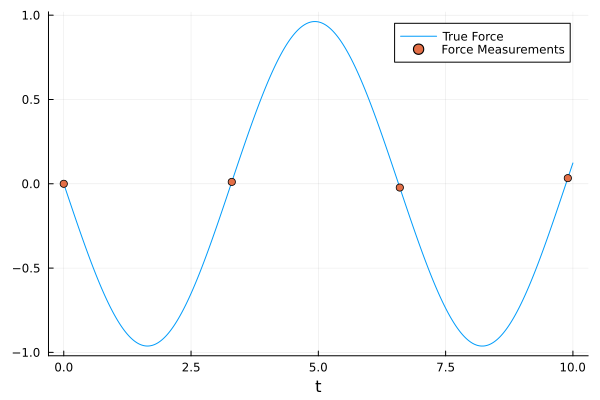

In [18]:
plot_t = 0:0.01:10

data_plot = sol(plot_t)
positions_plot = [state[2] for state in data_plot]
force_plot = [force(state[1], state[2], k, t) for state in data_plot]

# Generating the dataset
t = 0:3.3:10
dataset = sol(t)
position_data = [state[2] for state in sol(t)]
force_data = [force(state[1], state[2], k, t) for state in sol(t)]

plot(plot_t, force_plot, xlabel="t", label="True Force")
scatter!(t, force_data, label="Force Measurements")


Let's naively try and train a NN on these data:

In [24]:
NNForce = Chain(x -> [x],
            Dense(1 => 32, tanh),
            Dense(32 => 1),
            first) # This "first" makes sure we return a scalar

loss() = sum(abs2, NNForce(position_data[i]) - force_data[i] for i in 1:length(position_data))
loss()

opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())
Flux.train!(loss, Flux.params(NNForce), data, opt; cb=cb)

0.00018057280716798392

0.0001434261281041039

0.00012264343271488354

0.00010481818296999545

8.95391849963224e-5

7.645178135984987e-5

6.52484849664545e-5

5.56634976350524e-5

4.746821611303228e-5

4.046465646872708e-5

3.448189695611844e-5

Let's plot and see the accuracy with our intended behavior:

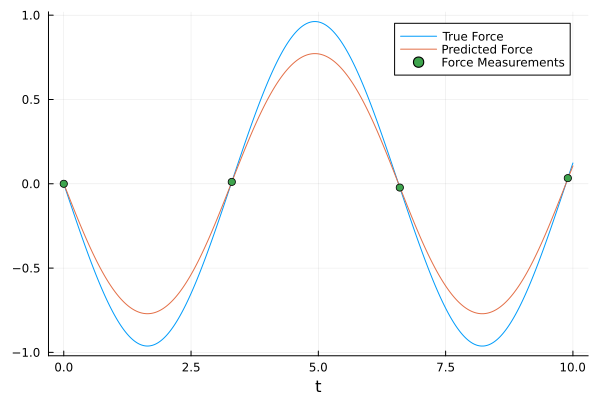

In [26]:
learned_force_plot = NNForce.(positions_plot)

plot(plot_t, force_plot, xlabel="t", label="True Force")
plot!(plot_t, learned_force_plot, label="Predicted Force")
scatter!(t, force_data, label="Force Measurements")

Not great––what if we add some physical intuition?

We know that we're modeling the behavior of a spring, so Hooke's law should ideally apply:
$$ F(x) = kx $$
How does this look compared to our actual model?

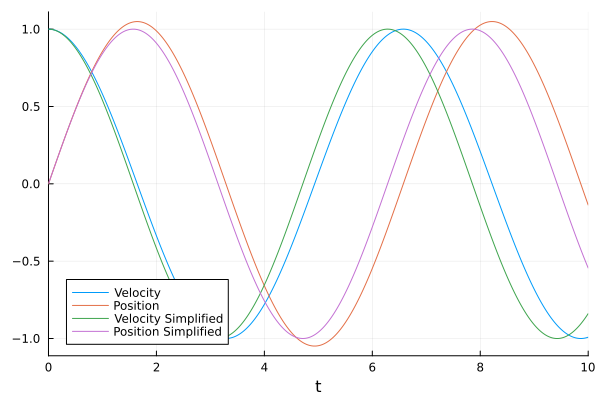

In [27]:
force2(dx, x, k, t) = -k*x
prob_simplified = SecondOrderODEProblem(force2, 1.0, 0.0, (0.0, 10.0), k)
sol_simplified = solve(prob_simplified)

plot(sol, label=["Velocity" "Position"])
plot!(sol_simplified, label=["Velocity Simplified" "Position Simplified"])

Not a great actual model, but can it help our fit if we add it to the NN?

In [31]:
random_positions = [2rand()-1 for i in 1:100]

# This is zero when F(x) = -kx, i.e. the spring behavior in an ideal scenario
loss_ode() = sum(abs2, NNForce(x) - (-k*x) for x in random_positions)
loss_ode()

2.151318169675487

In [33]:
# Let's compose the loss:

λ = 0.1 # Weight factor to control the regularization against the physics assumption
composed_loss() = loss() + λ*loss_ode()

# Train the PINN:

opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0

cb = function () #callback function to observe training
    global iter += 1
    if iter % 500 == 0
      display(composed_loss())
    end
  end
  display(composed_loss())

Flux.train!(composed_loss, Flux.params(NNForce), data, opt; cb=cb)

0.2151662988645048

0.00046974750743889875

0.0004460134442129833

0.00042483682540091824

0.00040574939177891883

0.00038840582811878197

0.0003725376351229369

0.000357938994917529

0.00034444636151991236

0.00033192289542860026

0.00032025958108771206

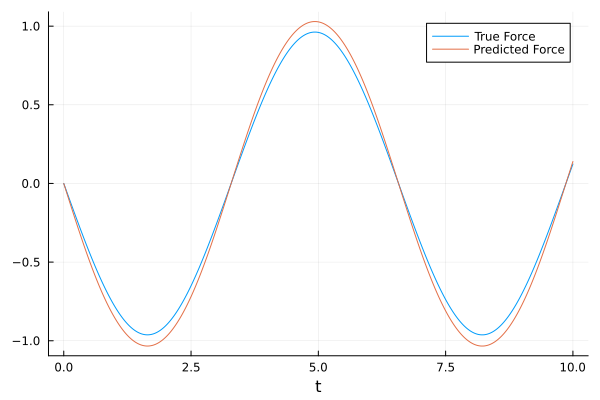

In [34]:
learned_force_plot = NNForce.(positions_plot)

plot(plot_t, force_plot, xlabel="t", label="True Force")
plot!(plot_t, learned_force_plot, label="Predicted Force")

And we get a better prediction by adding Hooke's law to our NN!

# Lecture 4: Loops/Dynamical Systems

## Single variable systems

Recall Banach's fixed point theorem: A contraction will have a unique fixed point. 

Consider some nice function, $f \in C^1$. Suppose that $\|f'(x^*)\| < 1$ for some fixed point $x^*$ such that $f(x^*) = x^*$. We then know that for some neighborhood $N$ of $x^*$,
$$ \forall x, y \in N, \quad \frac{\|f(x) - f(y)\|}{\|x - y\|} < 1 \Rightarrow \|f(x) - f(y)\| < \|x - y\|. $$
So $f$ is a contraction mapping on $N$, and therefore $x^*$ is a unique fixed point of $f$ on $N$.

What does this mean? Well, it means that for any function $f \in C^1$, not just a linear function, we can approximate the dynamical system
$$ x_{n+1} = f(x_n) $$
as
$$ x_{n+1} = f'(x) x_n, $$
and if $\|f'(x)\| < 1$, we know that we have local convergence to a fixed point and thus the dynamical system has a stable fixed point.

Here's some more intuition: we can rewrite the approximation above as 
$$ x_{n+1} = (f'(x))^n x_0, $$
and this we know converges for $\|f'(x)\| < 1$, and does so analytically.

## Multivariable systems

Let $x \in \mathbb{R}^k$ and $x_{n+1} = f(x_n)$. If $f$ is linear, we can write
$$ x_{n+1} = Ax_n, $$
or, more explicitly for two dimensions,
$$ a_{n+1} = \alpha a_n + \beta b_n $$
$$ b_{n+1} = \gamma a_n + \delta b_n. $$
How do we determine convergence here? Well, let's assume that $A$ is diagonalizable: $A = P^{-1}DP$, where 
$$ D = \begin{pmatrix} \lambda_1 & 0 & \dots & 0 \\ 0 & \lambda_2 & \dots & 0 \\ 0 & 0 & \ddots & \vdots \\ 0 & \dots & 0 & \lambda_k \end{pmatrix} $$
is the diagonal matrix of eigenvalues of $A$.

Let's change coordinates and let $z_n = Px_n$. We then have
$$ z_{n+1}^1 = \lambda_1 z_n^1 $$
$$ z_{n+1}^2 = \lambda_2 z_n^2 $$
$$ \vdots $$
$$ z_{n+1}^k = \lambda_2 z_n^k, $$
and convergence relies on $\|\lambda_i\| < 1$ for all $i = 1, 2, \dots, k$.

For nonlinear $f \in C^1$, we take $A$ to be the jacobian of $f$ and approximate near the fixed point.

## Delayed systems

What about a system of the form
$$ x_{n+1} = \sum_{j=0}^{k-1} \alpha_j x_{n-j} $$
Let's write this out:
$$ x_{n+1} = \alpha_0 x_n + \alpha_1 x_{n-1} + \dots + \alpha_{k-1} x_{n-k+1}. $$
But notice that we can write this out as a **multidimensional non-delayed system**.

Let $y_n^i$ be the $i$th term in the vector of the $n$ time. I.e.
$$ y_n = \begin{pmatrix} x_n \\ x_{n-1} \\ \vdots \\ x_{n-k+1} \end{pmatrix} $$
We then see that we can write
$$ y_{n+1}^{(1)} = x_{n+1} = \sum_{j=1}^{k-1} \alpha_{j-1} y_{n}^{{j}} $$
$$ y_{n+1}^{(2)} = x_n = y_n^{(1)} $$
$$ y_{n+1}^{(3)} = x_{n-1} = y_n^{(2)} $$
$$\vdots$$
And thus we can write
$$ y_{n+1} = A y_n, $$
where
$$ A = \begin{pmatrix} \alpha_0 & \alpha_1 & \dots & \alpha_{k-1} \\ 1 & 0 & \dots & 0 \\ 0 & 1 & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \end{pmatrix}. $$
It has a characteristic polynomial
$$ \phi (x) = 1 - \sum_{j=0}^{k-1} \alpha_j y^{(j)} $$
And, similarly to above, if all the eigenvalues have norms $< 1$ then the system is stable.

## Stochastic systems

Consider the system
$$ u_{n+1} = \sum_{j=0}^{k-1} \alpha_j u_{n-j} + \epsilon_n, $$
where $\epsilon_i$ are random perturbations.

We use the linearity of the expected value to notice that, assuming standard normal distribution of the $\epsilon_i$,
$$ \mathbb{E} [u_{n+1}] =  \sum_{j=0}^{k-1} \alpha_j \mathbb{E} [u_{n-j}] $$
and note that this is a **deterministic** linear dynamical system which converges according to the same conditions as above.